# 量子近似最適化アルゴリズム （QAOA）
本セクションでは量子近似最適化アルゴリズム（QAOA）の説明とMax-Cut問題に対してQAOAを適用していく。なお、Max-Cut問題とはグラフのノードを2つのグループに分割し、 **カットされる辺の数（または辺に重みがある場合はカットされる辺の重みの合計）** を最大化する問題です。この問題は、ネットワークの分割や画像処理（セグメンテーション）など、さまざまな応用があります。

In [1]:
import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ommx.v1
import qiskit.primitives as qk_pr
from scipy.optimize import minimize

import qamomile.core as qm
from qamomile.core.circuit.drawer import plot_quantum_circuit
import qamomile.qiskit as qm_qk

## QAOAとは
QAOAは、変分量子回路を用いる量子最適化アルゴリズムの一つである。
詳しい説明は論文 [1] を参照されたいが、ここでは概要のみを述べる。

QAOAでは、イジングハミルトニアン $H_P = \sum_{ij}J_{ij}Z_iZ_j$ と $X$ ミキサーハミルトニアン $H_M = \sum_iX_i$ を次のように適用することで、変分量子回路を構成する。初期状態 $\ket{\psi_0}$ から始めたとすると、

$$
\ket{\psi(\beta,\gamma)} = e^{-i\beta_pH_M}e^{-i\gamma_pH_P}\cdots e^{-i\beta_1H_M}e^{-i\gamma_1H_P}\ket{\psi_0}
$$

のように表せる。ここで、$\beta_k,\gamma_k$ は最適化すべきパラメータであり、$e^{-i\beta_kH_M}e^{-i\gamma_kH_P}$ の操作を $p$ 回繰り返すので、パラメータは全部で $2p$ 個ある。
標準的な QAOA においては、これらのパラメータの総数は量子ビットの数には依存せず、繰り返し回数 $p$ のみに依存する。

$\beta_k,\gamma_k$ の最適化は以下の手順を繰り返して行う：

1. 量子デバイス上で期待値 $\bra{\psi(\beta,\gamma)}H_P\ket{\psi(\beta,\gamma)}$ を計算する。
2. 古典コンピュータ上で期待値を最小化するようにパラメータを更新する。

このように、量子コンピュータ上での期待値計算と古典コンピュータによるパラメータの最適化を繰り返すことで、最小エネルギー $\langle H_P \rangle$ とそれに対応する最終状態を得る。  
QAOA を数学的な最適化アルゴリズムと見なすと、この最小エネルギーは目的関数の最小値に対応し、最終状態が最適解となる。

## 数理モデルの構築

In [2]:
def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    
    return problem

problem = Maxcut_problem()
problem

## インスタンスデータの準備
`JijModeling`を用いて数理モデルを構築したため、次は実際に解く問題(= 数値)を準備する。今回は5頂点を持つグラフを用いる。

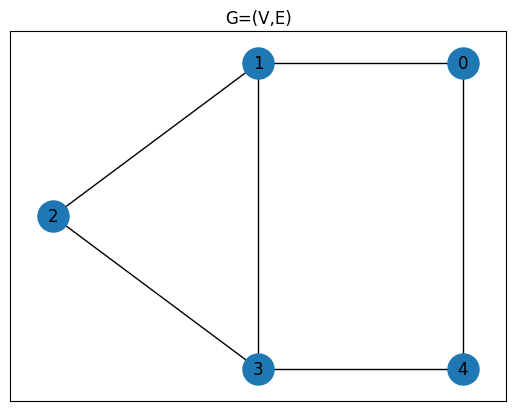

In [3]:
# グラフを作成する
G = nx.Graph()
num_nodes = 5
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

# インスタンスデータを準備する
instance_data = {"V": num_nodes, "E": edges}

# グラフを表示する
pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
plt.title("G=(V,E)")
plt.plot(figsize=(5, 4))
nx.draw_networkx(G, pos, node_size=500)

## コンパイル済みインスタンスの作成
先ほど準備した定式化とインスタンスデータを用いて、`JijModeling.Interpreter`と`ommx.Instance`を使ってコンパイルを行います。この処理により、インスタンスデータが代入された問題の中間表現が得られます。

In [4]:
interpreter = jm.Interpreter(instance_data)
compiled_model = interpreter.eval_problem(problem)

## コンパイル済みインスタンスからのQAOA回路とハミルトニアンへの変換
`qm.qaoa.QAOAConverter`を用いることで、コンパイル済みのインスタンスからQAOA回路とハミルトニアンを生成する変換器を作ることができます。

このクラスのインスタンスを作成し、`ising_encode`を用いることで、内部的にコンパイル済みインスタンスからIsingハミルトニアンを生成できます。QUBOへの変換時に必要となるパラメータもここで設定できます。設定しない場合は、デフォルト値が使用されます。

Isingハミルトニアンが生成された後は、それぞれQAOAの量子回路とハミルトニアンを生成できます。これらは `get_qaoa_ansatz`メソッドと`get_cost_hamiltonian`メソッドを使って取得します。ここでは、QAOAのレイヤー数$p$は$5$に固定されています。

なお、Qamomileはイジングハミルトニアン正規化機能を有しており、`QAOAConverter`インスタンス作成時の`normalize_ising`引数を指定することで機能を指定できます。2025年6月6日現在で以下の正規化手法が搭載されています。

- 正規化をしない（`None`（デフォルト値））
- 最大値の絶対値による正規化(`"abs_max"`)
- 二乗平均平方根（RMS）による正規化（`"rms"`）

イジングハミルトニアンの正規化の有無によって最終的に得られる結果が変わることもあるため、ぜひ使用してみてください。なお、後述するように今回の問題設定においては`"abs_max"`の結果と`"rms"`の結果のハミルトニアンは一致するため、正規化無しと`"abs_max"`だけを実施します。

In [5]:
# レイヤー数を設定する
p = 5

# 正規化無しのQAOA回路とハミルトニアンを作成する
qaoa_converter = qm.qaoa.QAOAConverter(compiled_model, normalize_ising=None) # デフォルト値がNoneのため、Noneを選択しなくても良い
qaoa_converter.ising_encode()
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

# 最大値の絶対値による正規化をしたQAOA回路とハミルトニアンを作成する
qaoa_converter_abs_max = qm.qaoa.QAOAConverter(compiled_model, normalize_ising="abs_max")
qaoa_converter_abs_max.ising_encode()
qaoa_hamiltonian_abs_max = qaoa_converter_abs_max.get_cost_hamiltonian()
qaoa_circuit_abs_max = qaoa_converter_abs_max.get_qaoa_ansatz(p=p)

## QAOA 回路の可視化
ハミルトニアン正規化はQAOA回路自体には関与しないため、どのQAOA回路を視覚化しても現時点では同じ回路図が表示されます。

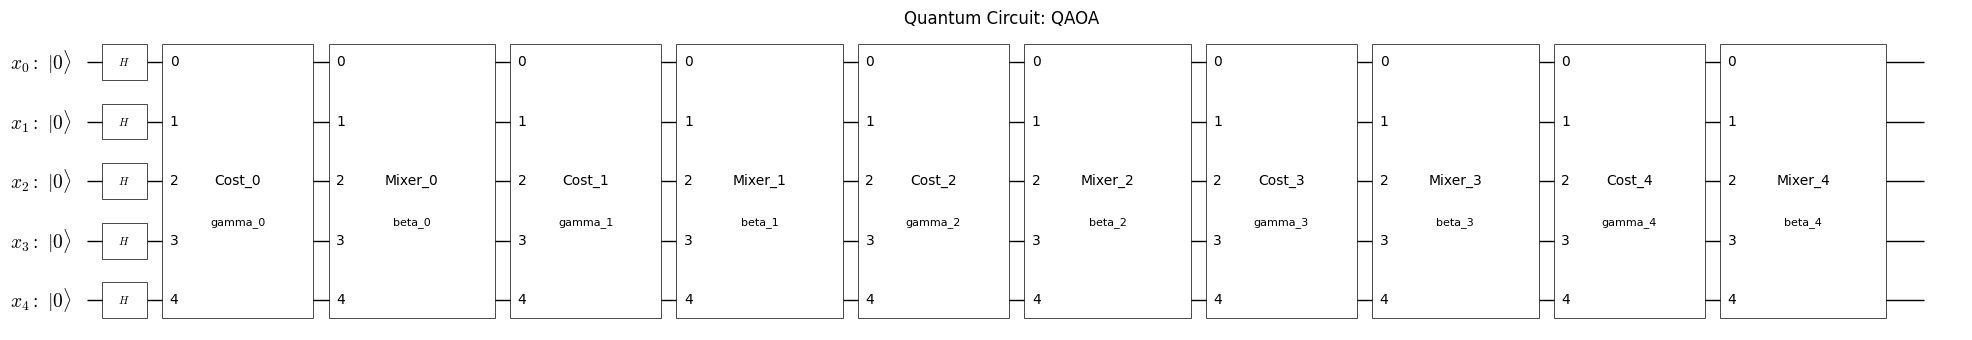

In [6]:
plot_quantum_circuit(qaoa_circuit)
# plot_quantum_circuit(qaoa_circuit_abs_max)

## 取得した QAOA 回路とハミルトニアンを Qiskit 向けに変換
ここでは`qamomile.qiskit.QiskitTranspiler`のコンバータを用いて、Qiskit用のQAOA回路とハミルトニアンを生成します。`QiskitTranspiler.transpile_circuit`メソッドと`QiskitTranspiler.transpile_hamiltonian`メソッドを利用することで、QAOA回路とハミルトニアンをQiskitに適した形式へと変換できます。

これにより、Qiskit の量子コンピューティングフレームワークを活用して実行および解析が可能となります。

In [7]:
qk_transpiler = qm_qk.QiskitTranspiler()

# QAOA回路をQiskit用に変換する
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
# QAOAハミルトニアンをQiskit用に変換する
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)

# 最大値の絶対値による正規化をしたQAOA回路をQiskit用に変換する
qk_circuit_abs_max = qk_transpiler.transpile_circuit(qaoa_circuit_abs_max)
# 最大値の絶対値による正規化をしたQAOAハミルトニアンをQiskit用に変換する
qk_hamiltonian_abs_max = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian_abs_max)

# 正規化をつけた時と付けない時でハミルトニアンが同じになるかどうかを確認する
print(f"Are qaoa_hamiltonian and qk_hamiltonian_abs_max the same?: {qk_hamiltonian == qk_hamiltonian_abs_max}")

Are qaoa_hamiltonian and qk_hamiltonian_abs_max the same?: False


## QAOA の実行

In [8]:
# 初期パラメータの作成
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)

In [9]:
# 正規化無し用の変分ステップ
estimator = qk_pr.StatevectorEstimator()
cost_history = []
def estimate_cost(param_values):
    try:
        job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
        result = job.result()[0]
        cost = result.data["evs"]
        cost_history.append(cost)
        return cost
    except Exception as e:
        print(f"Error during cost estimation: {e}")
        return np.inf

# QAOA最適化の実行
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000, "tol": 1e-2},
)
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.773868815731332
       x: [-5.352e-01 -1.183e-01  7.028e-01  6.848e-01  1.493e-01
            4.379e-01  6.596e-01  2.608e-01 -1.970e-01 -1.072e+00]
    nfev: 142
   maxcv: 0.0

In [10]:
# 最大値の絶対値による正規化用の変分ステップ
estimator_abs_max = qk_pr.StatevectorEstimator()
cost_history_abs_max = []
def estimate_cost_abs_max(param_values):
    try:
        job = estimator_abs_max.run([(qk_circuit_abs_max, qk_hamiltonian_abs_max, param_values)])
        result = job.result()[0]
        cost = result.data["evs"]
        cost_history_abs_max.append(cost)
        return cost
    except Exception as e:
        print(f"Error during cost estimation: {e}")
        return np.inf

# QAOA最適化の実行
result_abs_max = minimize(
    estimate_cost_abs_max,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000, "tol": 1e-2},
)
result_abs_max

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -9.303729872215158
       x: [-5.324e-01  7.279e-01  4.776e-01  1.150e+00 -6.193e-01
           -4.358e-01  5.014e-01  9.765e-01 -5.621e-01 -3.091e-01]
    nfev: 278
   maxcv: 0.0

## 結果の可視化

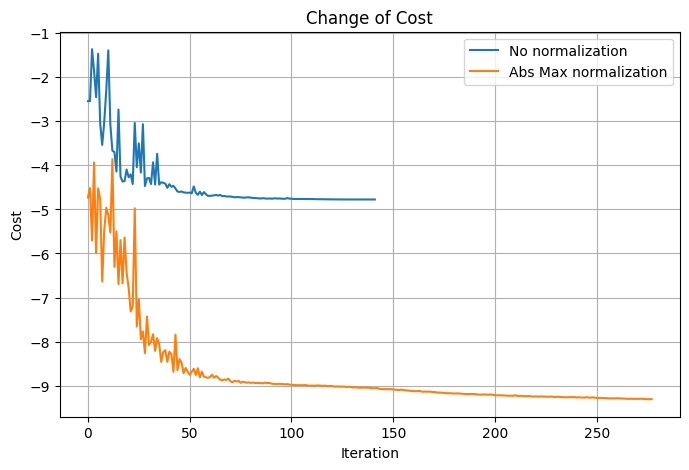

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(cost_history, label="No normalization")
plt.plot(cost_history_abs_max, label="Abs Max normalization")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Change of Cost")
plt.legend()
plt.grid(True)
plt.show()

## 結果の評価
先ほど取得したジョブのカウント情報から、`qaoa_converter.decode`を用いてsamplesetに変換することができます。samplesetでは、実行可能な解（feasible solutions）のみを選択することができ、目的関数の値の分布を調べることができます。

In [12]:
sampler = qk_pr.StatevectorSampler()

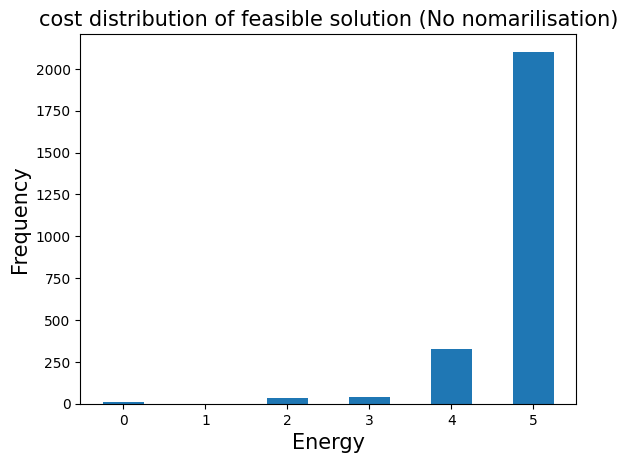

In [13]:
# 最適化済みの正規化無しのQAOA回路を実行結果を取得する
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])
energies = []
frequencies = []
for entry in sampleset.raw.objectives.entries:
    energies.append(entry.value)
    frequencies.append(len(entry.ids))

plt.bar(energies, frequencies, width=0.5)
plt.title("cost distribution of feasible solution (No nomarilisation)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()

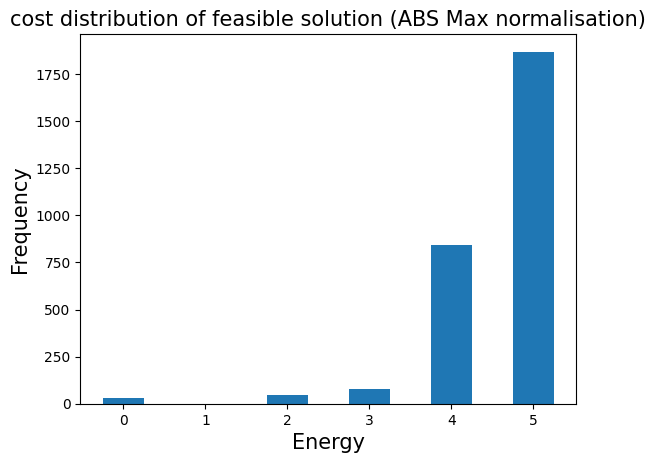

In [14]:
# 最適化済みの正規化無しのQAOA回路を実行結果を取得する
qk_circuit_abs_max.measure_all()
job_abs_max = sampler.run([(qk_circuit_abs_max, result_abs_max.x)], shots=10000)
job_result_abs_max = job_abs_max.result()[0]
sampleset_abs_max = qaoa_converter.decode(qk_transpiler, job_result_abs_max.data["meas"])
energies_abs_max = []
frequencies_abs_max = []
for entry in sampleset_abs_max.raw.objectives.entries:
    energies_abs_max.append(entry.value)
    frequencies_abs_max.append(len(entry.ids))

plt.bar(energies_abs_max, frequencies_abs_max, width=0.5)
plt.title("cost distribution of feasible solution (ABS Max normalisation)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()

## 解のプロット

In [15]:
def get_edge_colors(
    graph, cut_solution, in_cut_color="r", not_in_cut_color="b"
) -> tuple[list[str], list[str]]:
    cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9b26" for node in G.nodes()]
    return edge_colors, node_colors

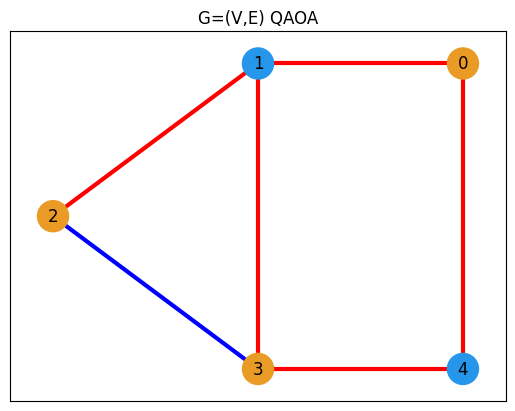

In [16]:
best_values = sampleset.best_feasible_unrelaxed().extract_decision_variables("x")
edge_colors, node_colors = get_edge_colors(G, best_values)

plt.title("G=(V,E) QAOA")
plt.plot(figsize=(5, 4))
nx.draw_networkx(
    G,
    pos,
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)

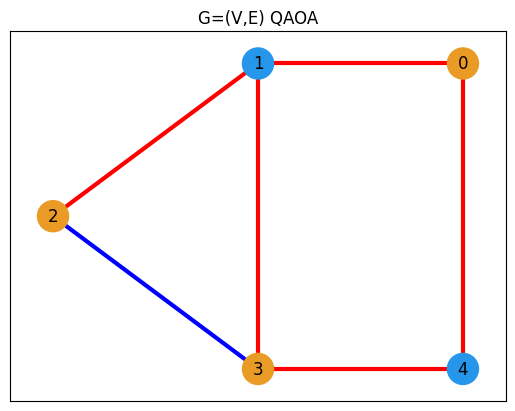

In [17]:
best_values = sampleset_abs_max.best_feasible_unrelaxed().extract_decision_variables("x")
edge_colors, node_colors = get_edge_colors(G, best_values)

plt.title("G=(V,E) QAOA")
plt.plot(figsize=(5, 4))
nx.draw_networkx(
    G,
    pos,
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)